# MIRIAD dataset

Evaluate the differences between T1-w images in MIRIAD dataset. This dataset is composed of 69 AD and HC subjects. For each subjects, up to 10 time points are available. Image resolution is $0.93 \times 0.93 \times 1.5$.  

We evaluate the performance of BET, ROBEX and PARIETAL infering the brain cavity for each of the time points. We compute the differences in the brain cavity and the brain volume error between each of the timepoints. 

In [1]:
import nibabel as nib
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Configuration

In [2]:
IMAGE_PATH = '/home/sergivalverde/DATA/miriad'
METHODS = ['BET', 'ROBEX', 'CONSNET', 'PARIETAL', 'PARIETAL1mm']
VOXEL_SIZE = [0.93, 0.93, 1.5]
SCANS = sorted(os.listdir(IMAGE_PATH))
PROCESSED_SCANS = len(SCANS)

In [3]:
def get_subject_information(scan_name):
    """
    Get relevant information from the subject ID.
    scan name is miriad_/pat_number/_/disease/_/sex/_/timepoint/_MR_/scan_num/

    input:

    """
    ind_ = [m.start() for m in re.finditer('_', scan_name)]

    scan_info = {}
    scan_info['scan_number'] = scan_name[ind_[0] + 1:ind_[1]]
    scan_info['disease_type'] = scan_name[ind_[1] + 1:ind_[2]]
    scan_info['subject_sex'] = scan_name[ind_[2] + 1:ind_[3]]
    scan_info['timepoint'] = int(scan_name[ind_[3] + 1:ind_[4]])
    scan_info['scan_num'] = int(scan_name[ind_[5] + 1:])

    return scan_info

## Evaluate data

In [6]:
brain_cavities = np.zeros((len(METHODS), PROCESSED_SCANS, 10, 10))
error_x_basal = np.zeros((len(METHODS), PROCESSED_SCANS, 10, 10))
disease_mask = np.zeros(PROCESSED_SCANS)
sex_mask = np.zeros(PROCESSED_SCANS)


for s, SCAN in enumerate(SCANS):

    if s >= PROCESSED_SCANS:
        continue

    current_scan = os.path.join(IMAGE_PATH, SCAN)
    timepoints = sorted(os.listdir(current_scan))

    for m, method in enumerate(METHODS):

        # load each of the timepoints and compare it with respect to the rest
        # of the timepoints
        for t in timepoints:
            t_info = get_subject_information(t)
            t_num = t_info['timepoint']
            t_scan_num = t_info['scan_num']
            
            
            if t_scan_num > 1:
                continue
                
            # set disease and sex
            disease = 1 if t_info['disease_type'] == 'AD' else 0
            sex = 1 if t_info['subject_sex'] == 'M' else 0
            sex_mask[s] = sex
            disease_mask[s] = disease
            

            # get the bbasal scan
            current_tm = os.path.join(current_scan, t)
            basal_image = nib.load(os.path.join(
                current_tm, method, 'brainmask.nii.gz')).get_fdata()

            for tt in timepoints:

                tt_info = get_subject_information(tt)
                tt_num = tt_info['timepoint']
                tt_scan_num = tt_info['scan_num']

                if tt_scan_num > 1:
                    continue

                # avoid processing the same case twice
                if tt_num <= t_num:
                    continue

                # print("processing:", SCAN, '(', method, ')',  t, '-->',  tt)
                # get the followp up scan
                current_tm = os.path.join(current_scan, tt)
                followup_image = nib.load(os.path.join(
                    current_tm, method, 'brainmask.nii.gz')).get_fdata()

                # compute diffs
                current_dif = abs(np.sum(basal_image) - np.sum(followup_image))
                brain_cavities[m, s, t_num - 1, tt_num - 1] = current_dif
                brain_cavities[m, s, tt_num - 1, t_num - 1] = current_dif
                error_x_basal[m, s, t_num - 1, tt_num - 1] = current_dif / np.sum(basal_image)
                error_x_basal[m, s, tt_num - 1, t_num - 1] = current_dif / np.sum(basal_image)



In [74]:
mask = [0, 1, 2, 3, 4, 5, 6, 8, 9]
brain_cavities = brain_cavities[:, :, mask]
brain_cavities = brain_cavities[:, :, :, mask]
error_x_basal = error_x_basal[:, :, mask]
error_x_basal = error_x_basal[:, :, :, mask]


In [75]:
reg_ml = np.prod(VOXEL_SIZE) / 1000
bet_cavities = np.mean(brain_cavities[0], axis=0) * reg_ml
robex_cavities = np.mean(brain_cavities[1], axis=0) * reg_ml
consnet_cavities = np.mean(brain_cavities[2], axis=0) * reg_ml
parietal3mm_cavities = np.mean(brain_cavities[3], axis=0) * reg_ml
parietal1mm_cavities = np.mean(brain_cavities[4], axis=0) * reg_ml


bet_error = np.mean(error_x_basal[0], axis=0) 
robex_error = np.mean(error_x_basal[1], axis=0) 
consnet_error = np.mean(error_x_basal[2], axis=0) 
parietal3mm_error = np.mean(error_x_basal[3], axis=0) 
parietal1mm_error = np.mean(error_x_basal[4], axis=0) 

activations = np.sum(brain_cavities[0] > 0, axis=0) / PROCESSED_SCANS


## Show global results per method

In [76]:
global_cavity_bet = np.mean(brain_cavities[0]) * reg_ml
global_cavity_robex = np.mean(brain_cavities[1]) * reg_ml
global_cavity_consnet = np.mean(brain_cavities[2]) * reg_ml
global_cavity_parietal3mm = np.mean(brain_cavities[3]) * reg_ml
global_cavity_parietal1mm = np.mean(brain_cavities[4]) * reg_ml

global_error_bet = np.mean(error_x_basal[0]) 
global_error_robex = np.mean(error_x_basal[1]) 
global_error_consnet = np.mean(error_x_basal[2])
global_error_parietal3mm = np.mean(error_x_basal[3])
global_error_parietal1mm = np.mean(error_x_basal[4])

print('BET', global_cavity_bet, '.ml')
print('ROBEX', global_cavity_robex, '.ml')
print('CONSNET', global_cavity_consnet, '.ml')
print('PARIETAL 3mm', global_cavity_parietal3mm, '.ml')
print('PARIETAL 1mm', global_cavity_parietal1mm, '.ml')
print('------------------------')
print('Error BET', global_error_bet * 100,'%')
print('Error ROBEX', global_error_robex * 100, '%')
print('Error CONSNET', global_error_consnet * 100, '%')
print('Error PARIETAL_3mm', global_error_parietal3mm * 100, '%')
print('Error PARIETAL_1mm', global_error_parietal1mm * 100, '%')
print('------------------------')


BET 70.4424165241546 .ml
ROBEX 7.300428700000001 .ml
CONSNET 13.809060716425124 .ml
PARIETAL 3mm 5.707185407246379 .ml
PARIETAL 1mm 5.595418321739132 .ml
------------------------
Error BET 4.576188817963466 %
Error ROBEX 0.5311095863235367 %
Error CONSNET 1.1440555616791106 %
Error PARIETAL_3mm 0.4636897682807264 %
Error PARIETAL_1mm 0.45569771945295934 %
------------------------


## Frequency between timepoints

In [134]:
sns.set()
mask = np.triu(np.ones_like(bet_cavities, dtype=np.bool))
cmap = sns.diverging_palette(145, 10, as_cmap=True)


[Text(0.5, 1, ' % of timepoint frequencies. 69 cases')]

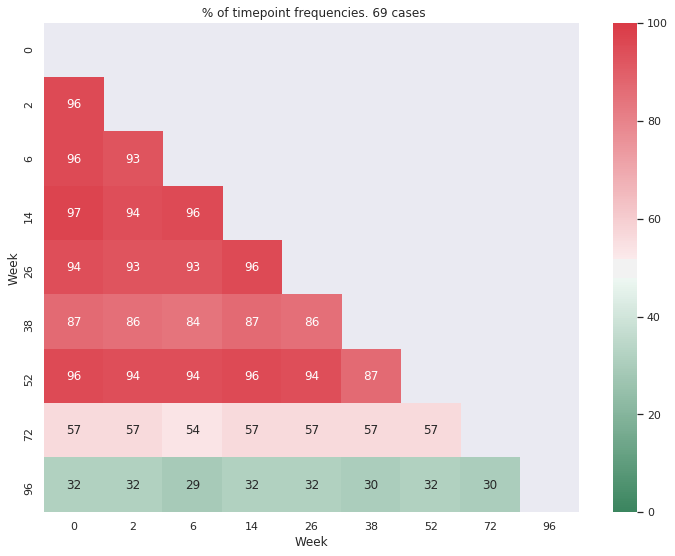

In [135]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(activations * 100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=100)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(title=" % of timepoint frequencies. {} cases".format(PROCESSED_SCANS))

## Differences in brain cavity

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

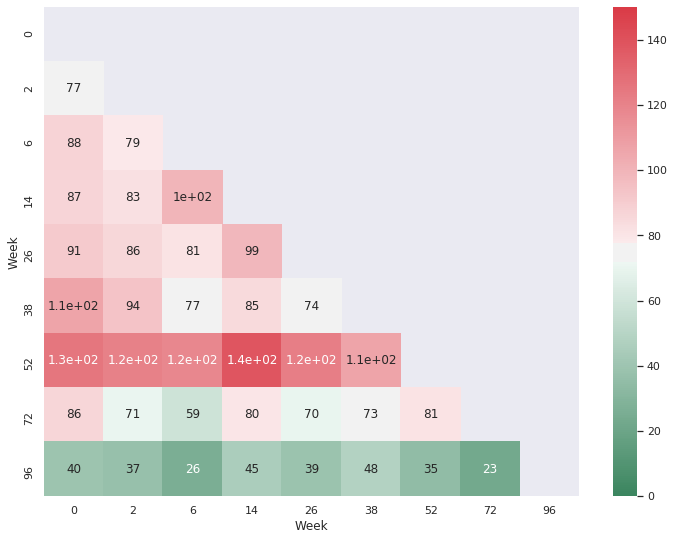

In [137]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(bet_cavities, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=150)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="BET (Differences in brain cavity) MEAN: {:.2f}.ml".format(global_cavity_bet))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

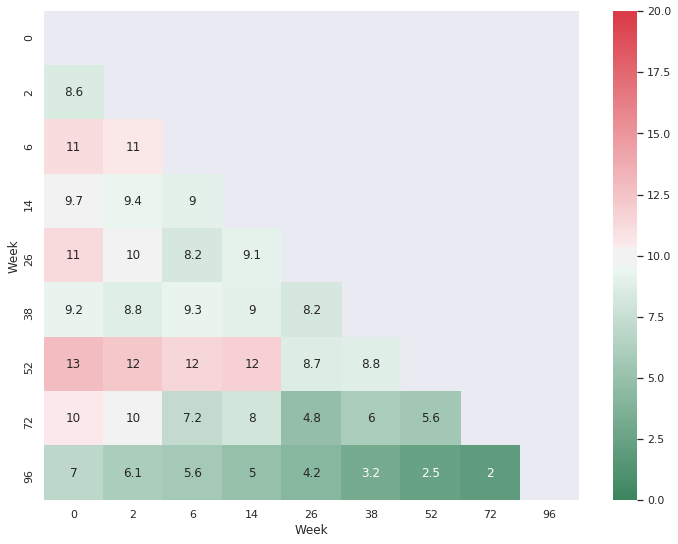

In [142]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(robex_cavities, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=20)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="ROBEX (Differences in brain cavity) MEAN: {:.2f}.ml".format(global_cavity_robex))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

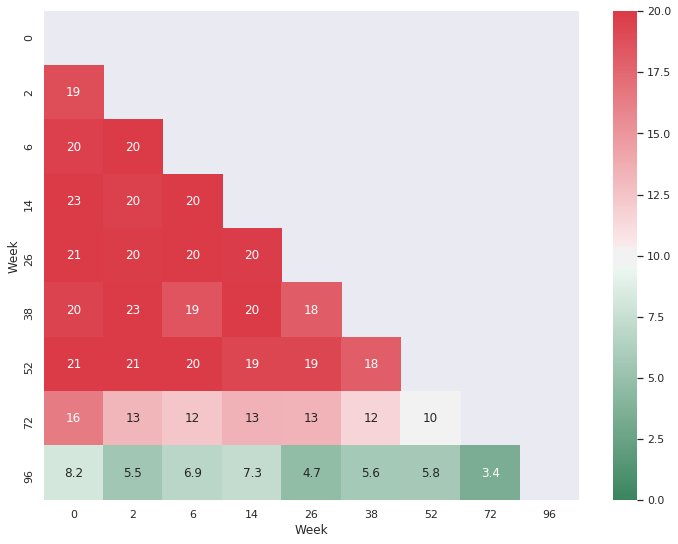

In [143]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(consnet_cavities, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=20)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(xlabel="Timepoint number", ylabel = "Timepoint number")
# ax.set(title="CONSNET (Differences in brain cavity) MEAN: {:.2f}.ml".format(global_cavity_consnet))

[Text(0.5, 1, 'PARIETAL 3mm (Differences in brain cavity) MEAN: 4.62.ml')]

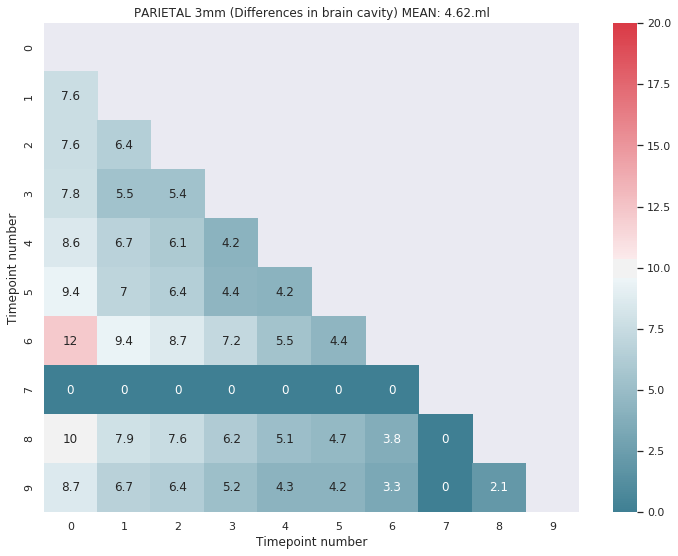

In [23]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(parietal3mm_cavities, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=20)
ax.set(xlabel="Timepoint number", ylabel = "Timepoint number")
ax.set(title="PARIETAL 3mm (Differences in brain cavity) MEAN: {:.2f}.ml".format(global_cavity_parietal3mm))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

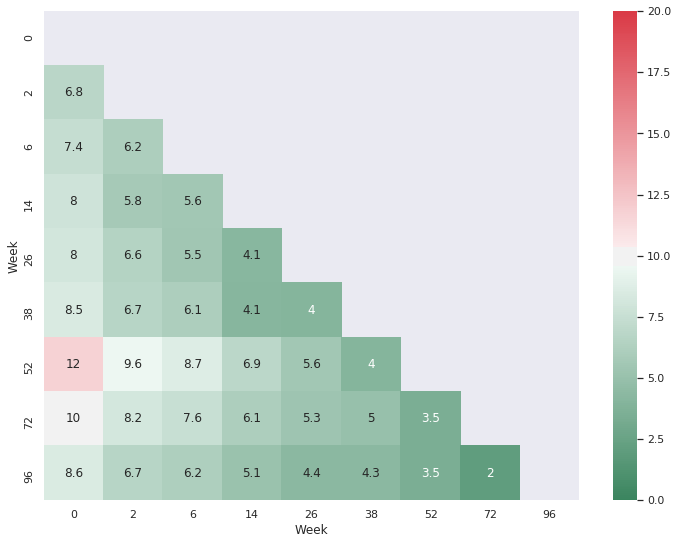

In [144]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(parietal1mm_cavities, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=20)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="PARIETAL 1mm (Differences in brain cavity) MEAN: {:.2f}.ml".format(global_cavity_parietal1mm))

## Percentage of brain volume error

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

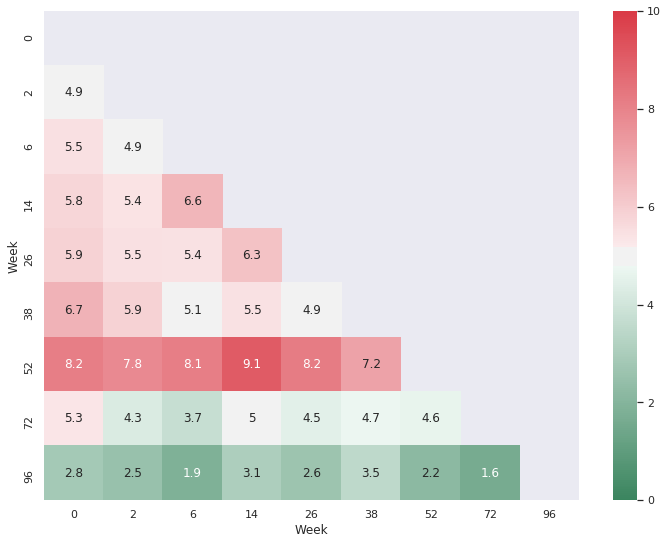

In [145]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(bet_error*100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=10)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="BET (% of brain error between timepoints) MEAN: {:.2f}%".format(global_error_bet * 100))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

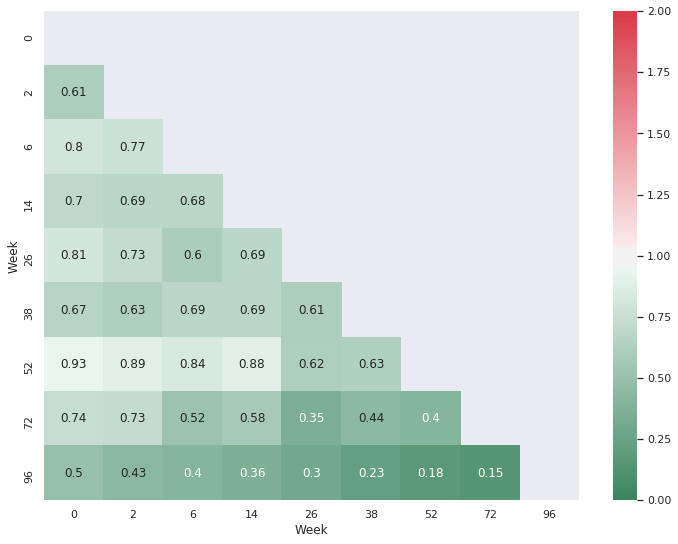

In [146]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(robex_error*100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=2)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="ROBEX (% of brain error between timepoints) MEAN: {:.2f}%".format(global_error_robex * 100))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

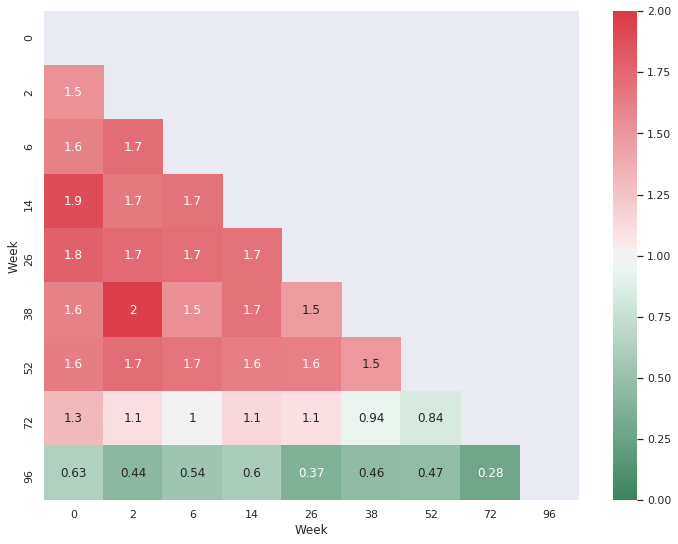

In [148]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(consnet_error*100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=2)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="CONSNET (% of brain error between timepoints) MEAN: {:.2f}%".format(global_error_consnet * 100))

[Text(0.5, 1, 'PARIETAL 3mm(% of brain error between timepoints) MEAN: 0.38%')]

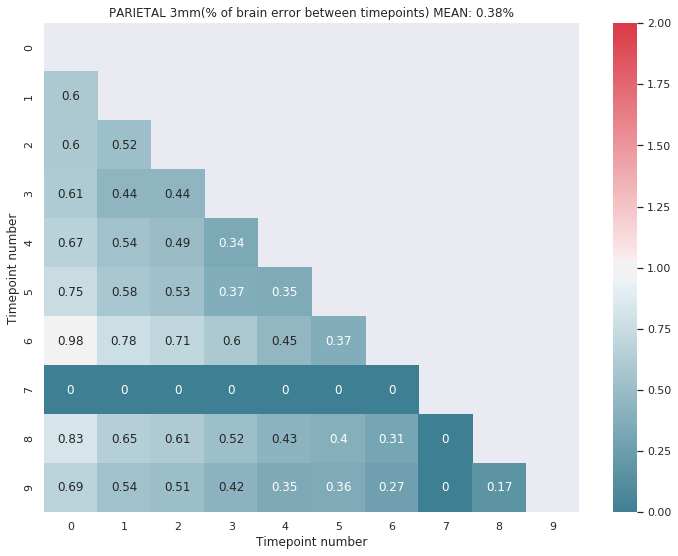

In [32]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(parietal3mm_error*100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=2)
ax.set(xlabel="Timepoint number", ylabel = "Timepoint number")
ax.set(title="PARIETAL 3mm(% of brain error between timepoints) MEAN: {:.2f}%".format(global_error_parietal3mm * 100))

[[Text(0, 0.5, '0'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '6'),
  Text(0, 3.5, '14'),
  Text(0, 4.5, '26'),
  Text(0, 5.5, '38'),
  Text(0, 6.5, '52'),
  Text(0, 7.5, '72'),
  Text(0, 8.5, '96')]]

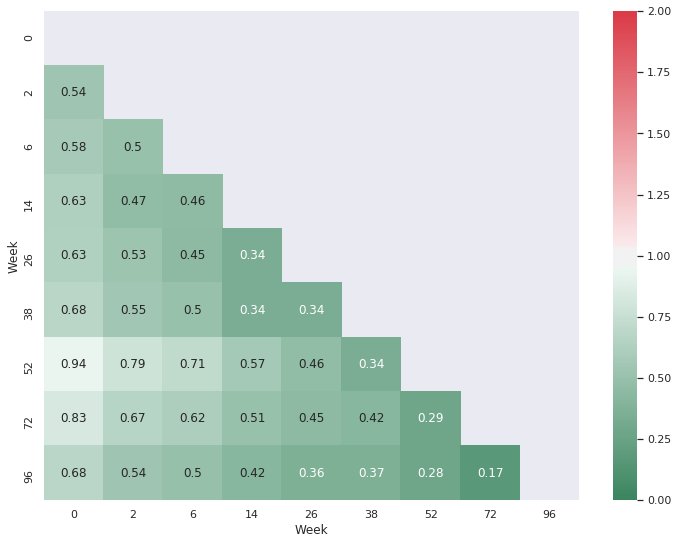

In [149]:
ax = plt.figure(figsize=(12, 9))
ax = sns.heatmap(parietal1mm_error*100, cmap=cmap, mask=mask, annot=True, vmin=0, vmax=2)
ax.set(xlabel="Week", ylabel = "Week")
ax.set(xticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
ax.set(yticklabels=['0', '2', '6', '14', '26', '38', '52', '72', '96'])
# ax.set(title="PARIETAL 1mm (% of brain error between timepoints) MEAN: {:.2f}%".format(global_error_parietal1mm * 100))

## Store data for further processing

In [236]:
dif_brain_cavities = np.transpose([brain_cavities[0].flatten(), 
                          brain_cavities[1].flatten(),
                          brain_cavities[2].flatten(),
                          brain_cavities[4].flatten()])
error_brain_volume= np.transpose([error_x_basal[0].flatten(), 
                                  error_x_basal[1].flatten(),
                                  error_x_basal[2].flatten(),
                                  error_x_basal[4].flatten()])

Remove 0s from the generated files

In [256]:
dif_brain_cavities = dif_brain_cavities[dif_brain_cavities[:,0] > 0]
error_brain_volume = error_brain_volume[error_brain_volume[:,0] > 0]

In [254]:
np.savetxt('miriad_dif_volume.csv', dif_brain_cavities, delimiter=',')
np.savetxt('error_brain.csv', error_brain_volume, delimiter=',')